### Clustering and Running MCMC 

AM207 Fantasy Basketball Prediction

#### Introduction
One of the problem we had in previous PyMC versions was too many parameters. With the limited data, it was really hard for us to get converged values. We tried to use PyMC3, however, with very limited documentations, we weren't able to get it done on time. So what is the problem with too many parameters? We could understand it as the over-fitting situation when a little bit noise will cause the unstable of the entire model. So it's very hard to get a converged value.

As such, we decided to reduce our dimensions. We grouped our players into 10 groups and optimize those 20 parameters. 

Our previous results also shows that some very good players got very bad scores. We clusters all of our over four hundred players into ten groups by their offensive ratings and defensive ratings(Using K-Means). We then use their cluster mean value to approaximate the group's. The assumption we made here also makes sense, as players who share the same offensive/defensive ratings shall have similar contributions in their teams. It is unlikely a very good player did a super bad job in one game if all other conditions keep the same. 

Our result shows that most of $\beta$ and $\gamma$ parameters converged. We use those optimal values and rank our players again in this section.

Although we got much more values converged(judged by Geweke Test), some of them still not yet. From the result shown below, we see ranking makes much more sense than previous PyMC methods.



In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
import pickle

/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/xdai/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Clustering 

In [126]:
# import the player_info from the cleaned folder, and normalize(standardize) their values before we clusters players
game16_df = pd.read_csv('clean-data/game_outcomes_15-16.csv')
player_info = pd.read_csv('clean-data/player_info_pergame.csv')
player_info["off_rating"] = player_info['PTS'].values + player_info['AST'].values
player_info["def_rating"] = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values
player_val = player_info[['off_rating','def_rating']]
df_norm = (player_val - player_val.mean(axis = 0))/ player_val.std(axis = 0)
df_norm = df_norm.fillna(0)

In [3]:
# Call K-means method
from sklearn import cluster
k_means = cluster.KMeans(init = "k-means++",n_clusters=10)
k_means_clusters = k_means.fit_predict(df_norm.values) 

### Run MCMC 

In [9]:
# import the pickle files for guest/host teams line_up and calculate score_diff
with open('clean-data/guest_team_line_up.pkl', 'rb') as handle:
    guest_team_line_up = pickle.load(handle)
with open('clean-data/host_team_line_up.pkl','rb') as handle:
    host_team_line_up = pickle.load(handle)
score_diff = game16_df['diff'].values

In [10]:
def make_guest_host_mat(game_outcomes_df):
    '''
    Makes a matrix for guests and hosts. Each row of each
    matrix corresponds to one matchup. All elements of each row
    are zero except the ith one (different for each row).
    For the guest matrix, the ith entry in row j means that in game j,
    the guest team was team i. In the host matrix, the ith entry in
    row j means that the host team was team i
    '''
    
    def make_matrix(mat, indices):
        '''given a matrix and indices, sets the right one in each row
        to be true'''
        for (i, ind) in enumerate(indices):
            mat[i, ind] = True
        
    nrows = game_outcomes_df.shape[0]
    ncols = np.max(game_outcomes_df['Visitor_Index'] + 1)
    
    guest_matrix = np.zeros((nrows, ncols), dtype = bool)
    host_matrix = np.zeros((nrows, ncols), dtype = bool)
    
    make_matrix(guest_matrix, game_outcomes_df['Visitor_Index'].values)
    make_matrix(host_matrix, game_outcomes_df['Home_Index'].values)
    
    return(guest_matrix, host_matrix)

In [11]:
guest_matrix, host_matrix = make_guest_host_mat(game16_df)
guest_lineup_arr = np.array(guest_team_line_up)
host_lineup_arr = np.array(host_team_line_up)
off_rating = player_info['PTS'].values + player_info['AST'].values
def_rating = player_info['BLK'].values + player_info["STL"].values + player_info['DRB'].values

In [13]:
def split_params(coefs, nplayers, nteams):
    '''
    Split the parameters
    first are the beta0 for each team
    then the beta for each player
    then the gamma0 for each team
    then the gamma for each player'''
    assert(coefs.shape == (2*(nplayers+nteams),))
    
    beta0 = coefs[:nteams]
    beta_player = coefs[nteams:(nplayers + nteams)]
    gamma0 = coefs[(nplayers + nteams):(nplayers + 2*nteams)]
    gamma_player = coefs[(nplayers + 2*nteams):]
    
    # parameterize sigma by its log
    #logsigma = coefs[-1]
    
    assert(beta0.shape == (nteams,))
    assert(beta_player.shape == (nplayers,))
    assert(beta0.shape == (nteams,))
    assert(gamma_player.shape == (nplayers,))
    
    
    return (beta0, beta_player, gamma0, gamma_player)#, logsigma)

In [14]:
# Construct beta and gamma 
team_num = 30
param_num = 10
coefs = pm.MvNormalCov("coefs", mu = np.zeros(2*(team_num + param_num)),
                      C = np.eye(2*(team_num + param_num)))
tau = pm.Gamma("tau", alpha = 2, beta = 2)

In [15]:
# construct new cluster label matrix
# k_means_clusters.shape
players_labels = []
cluster_num = 10
for i in range(k_means_clusters.shape[0]):
    new_labels = np.array([0] * cluster_num)
    new_labels[k_means_clusters[i]] = 1
    players_labels.append(new_labels)

In [16]:
players_labels_arr = np.array(players_labels)
host_clusters = np.dot(host_lineup_arr,players_labels_arr)
guest_clusters = np.dot(guest_lineup_arr,players_labels_arr)

In [17]:
# K-Means Mean Values
off_rating_means = k_means.cluster_centers_[:,0]
def_rating_means = k_means.cluster_centers_[:,1]


In [19]:
# Use a different log-likelihood
@pm.observed(name = "loglik", observed = True)
def loglik(coefs = coefs, tau = tau, value = score_diff, 
            off_rating = off_rating_means, def_rating = def_rating_means, 
            nplayers = cluster_num, nteams = team_num,
            guest_matrix = guest_matrix, host_matrix = host_matrix, guest_lineup_arr = guest_clusters,
            host_lineup_arr = host_clusters):

    beta0, betas, gamma0, gammas = \
             split_params(coefs, nplayers, nteams)
    
    ngames = value.shape[0]
    
    guest_off_0 = np.dot(guest_matrix, beta0)
    guest_def_0 = np.dot(guest_matrix, gamma0)
    host_off_0 = np.dot(host_matrix, beta0)
    host_def_0 = np.dot(host_matrix, gamma0)
    
    guest_off = guest_off_0 + np.dot(guest_lineup_arr, betas * off_rating)
    guest_def = guest_def_0 + np.dot(guest_lineup_arr, gammas * def_rating)
    host_off = host_off_0 + np.dot(host_lineup_arr, betas * off_rating)
    host_def = host_def_0 + np.dot(host_lineup_arr, gammas * def_rating)
    
    mean = guest_off - host_def - (host_off - guest_def)
    
    loglik = pm.normal_like(value, mean, tau)
    return(loglik)

In [20]:
parameterlist = [loglik, coefs, tau]
response_model=pm.Model(parameterlist)

In [21]:
mcmc = pm.MCMC(response_model)

In [28]:
mcmc.sample(iter=1500000, burn = 150000, thin = 1)

 [-----------------100%-----------------] 1500000 of 1500000 complete in 1828.3 sec

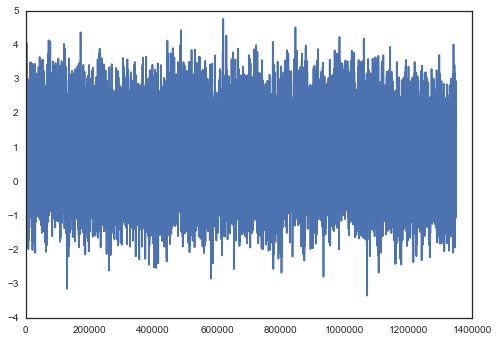

In [29]:
plt.plot(coefs.trace()[:, 18])

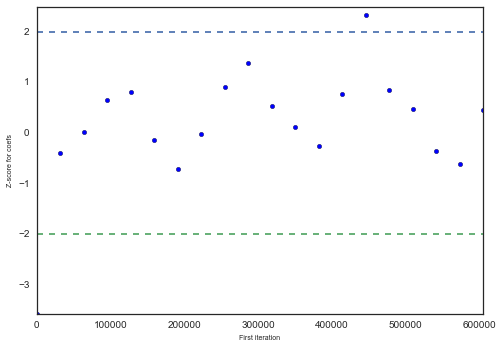

In [134]:
geweke_res = pm.geweke(coefs.trace()[140000:,50])
pm.Matplot.geweke_plot(geweke_res,'coefs')



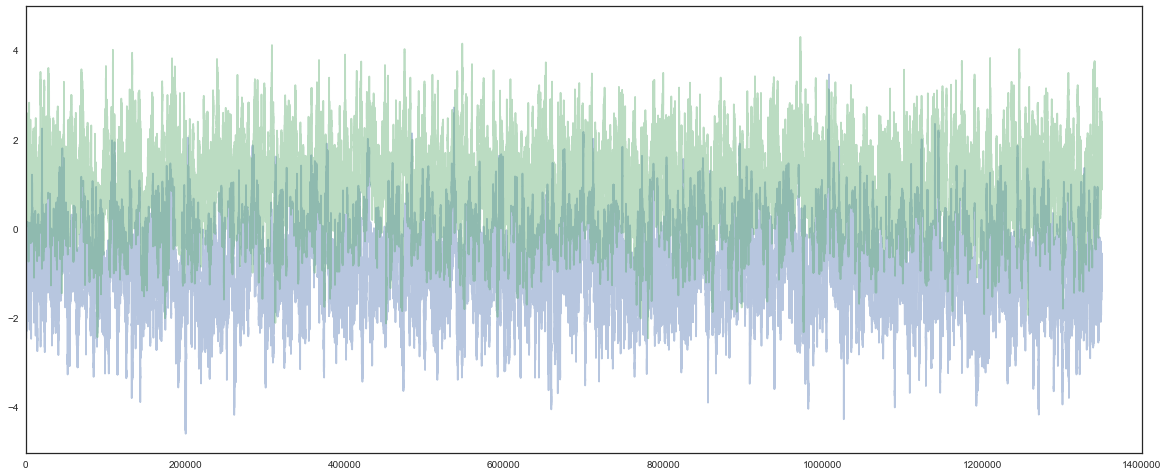

In [57]:
#comparision of multiple chain
plt.figure(figsize=[20,8])
plt.plot(coefs.trace[:,13],alpha=0.4)
plt.plot(coefs.trace[:,16],alpha=0.4)
    
# #geweke test Geweke(trace, intervals, length):
# num_interval = 20
# num_sample = 1000
# trace,acc = metropolis(num_sample,init_val,step_size,doPrint=False)
# z_score = Geweke(trace[:,0],num_interval,num_sample/num_interval)
# fig3= plt.figure()
# #plt.title('geweke convergence test')
# plt.plot(np.linspace(0,num_sample,num_interval),z_score,'.')
# #plt.ylabel()
# geweke_scores = pm.geweke(trace[:,0], first =0.1, last=0.5, intervals=num_interval)
# pm.Matplot.geweke_plot(geweke_scores, "lambda")

In [127]:
len(player_info)

468

### Use our new method to rank players

In [60]:
# Save mcmc to csv file 
mcmc.write_csv("pymcResult.csv")

In [61]:
res_df = pd.read_csv("pymcResult.csv")

In [77]:
beta0, beta_cluster, gamma0, gamma_cluster = split_params(res_df[' Mean'].values[:-1],param_num,team_num)

In [111]:
players_beta = []
players_gamma = []
for cluster in k_means_clusters:
    players_beta.append(off_rating_means[cluster])
    players_gamma.append(def_rating_means[cluster])
players_beta = np.array(players_beta)
players_gamma = np.array(players_gamma)

In [112]:
player_info["beta"] = np.multiply(players_beta, off_rating)
player_info["gamma"] = np.multiply(players_gamma, def_rating)

In [122]:
# result = player_info[['Player', 'off_rating', 'def_rating']]
# result
ranking_info = player_info[['Player','beta','gamma']]

In [124]:
ranking_info.sort_values('beta', ascending=False)

,Player,beta,gamma
64,Stephen Curry,111.892686,12.297513
25,James Harden,110.980517,13.545087
18,Russell Westbrook,103.075056,14.792661
7,Kevin Durant,100.946662,17.466034
2,LeBron James,97.602044,14.257987
24,John Wall,91.520920,12.653963
17,Paul George,82.703290,14.792661
16,Blake Griffin,79.966784,14.614436
3,Carmelo Anthony,79.054615,13.901537
173,Damian Lillard,69.031052,2.337387


In [125]:
ranking_info.sort_values('gamma', ascending=False)

,Player,beta,gamma
13,DeAndre Jordan,17.780015,43.538192
380,Hassan Whiteside,18.675411,42.228772
209,Andre Drummond,21.745342,41.901418
36,DeMarcus Cousins,38.629960,39.609934
102,Pau Gasol,26.350237,37.645805
105,Anthony Davis,33.513409,37.318450
4,Dwight Howard,19.314980,36.009031
37,Draymond Green,27.373548,35.026966
347,Rudy Gobert,13.558860,34.044902
128,Karl-Anthony Towns,25.966496,33.062837
